In [13]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.utils import median_survival_times
from lifelines.statistics import proportional_hazard_test

In [14]:
emp = pd.read_csv("../data/attrition.csv")

In [15]:
emp = emp[emp.YearsAtCompany != 40]
emp = emp.drop(index=1111).reset_index(drop=True)
emp = emp.drop(index=748).reset_index(drop=True)

In [17]:
print(emp.Gender.unique())
print(emp.Department.unique())
print(emp.JobLevel.unique())

['Female' 'Male']
['Sales' 'Research & Development' 'Human Resources']
[2 1 3 4 5]


In [18]:
def plot_lifelines(obs):
    for y, row in obs.iterrows():
        start = row['start']
        end = row['end']
        status = row['status']
        
        if status == 0:
            plt.hlines(y, start, end, color='C0')
        else:
            plt.hlines(y, start, end, color='C1')
            plt.plot(end, y, marker='o', color='C1')
            
    plt.xlabel('Time (weeks)')
    plt.ylabel('Index')
    plt.gca().invert_yaxis()

Text(0.5, 0, 'Duration (years)')

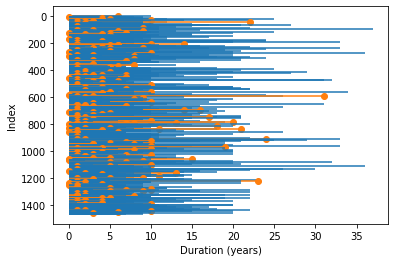

In [19]:
shifted = emp.copy()
shifted['start'] = 0
shifted['end'] = emp['YearsAtCompany']
shifted['status'] = emp['Attrition'].map({'Yes': 1, 'No': 0})
shifted['GenderBin'] = emp['Gender'].map({'Female': 1, 'Male': 0})

plot_lifelines(shifted)
plt.xlabel('Duration (years)')

In [20]:
ts = emp['YearsAtCompany'].unique()
ts.sort()
E, T = np.meshgrid(shifted['end'], ts)
at_risk = (T <= E).sum(axis=1)

#### Estimating hazard function

In [21]:
churned = pd.Series(0, index=ts)

for t in ts:
    k = (shifted['status'] == 1) & (t == shifted['end'])
    churned[t] = k.sum()

churn_times = np.where(shifted['status'], shifted['end'], np.nan)
A, T = np.meshgrid(churn_times, ts)
churned = (T == A).sum(axis=1)

In [22]:
d = dict(churned=churned, 
         at_risk=at_risk)
dfc = pd.DataFrame(d, index=ts)
dfc.head()

dfc['hazard'] = dfc['churned'] / dfc['at_risk']
dfc.head()

,churned,at_risk,hazard
0,16,1467,0.010907
1,59,1423,0.041462
2,27,1252,0.021565
3,20,1125,0.017778
4,19,997,0.019057


The hazard function is the probability of being churned at each duration, so its complement is the probability of not being churned.

In [23]:
dfc['surv'] = (1 - dfc['hazard']).cumprod()

The cumulative distribution function CDF is the complement of the survival function.

In [24]:
dfc['cdf'] = 1 - dfc['surv']

And the probability density function PMF is the difference between adjacent elements of the CDF.

In [25]:
dfc['pmf'] = np.diff(dfc['cdf'], prepend=0)
dfc.head()

,churned,at_risk,hazard,surv,cdf,pmf
0,16,1467,0.010907,0.989093,0.010907,0.010907
1,59,1423,0.041462,0.948084,0.051916,0.041009
2,27,1252,0.021565,0.927638,0.072362,0.020446
3,20,1125,0.017778,0.911147,0.088853,0.016491
4,19,997,0.019057,0.893783,0.106217,0.017364


#### Kaplan-Maier Curve Estimation (Non-Parametric)

In [26]:
kmf = KaplanMeierFitter()
T = shifted['end']
E = shifted['status']
kmf.fit(T, E)
kmf.survival_function_.head()

,KM_estimate
timeline,
0.0,0.989093
1.0,0.948084
2.0,0.927638
3.0,0.911147
4.0,0.893783


timelines includes an element at t=0, but other than that it is identical to what we computed (except for floating-point error).

In [27]:
max(abs(kmf.survival_function_['KM_estimate'] - dfc['surv']).dropna())

2.1094237467877974e-15

lifelines also computes a confidence interval for the survival function.

In [28]:
ci = kmf.confidence_interval_survival_function_

Text(0.5, 0, 'timeline (years)')

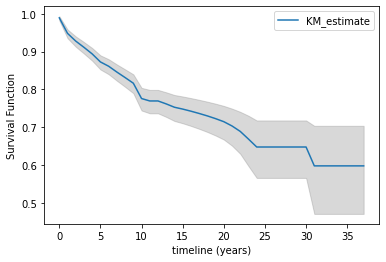

In [29]:
ts = ci.index
low, high = np.transpose(ci.values)

plt.fill_between(ts, low, high, color='gray', alpha=0.3)
kmf.survival_function_.plot(ax=plt.gca())
plt.ylabel('Survival Function')
plt.xlabel('timeline (years)')

Median Survival Time and Confidence Intervals

In [30]:
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print(median_)
print(median_confidence_interval_)

inf
     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                    31.0                     inf


KM plots by category

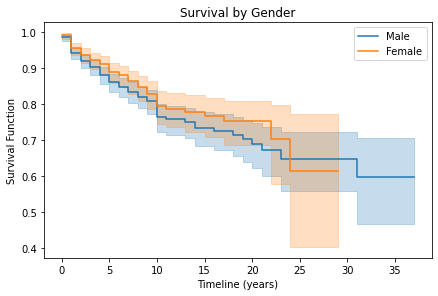

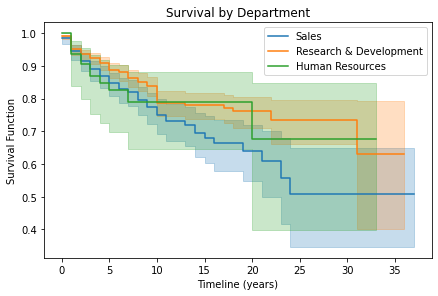

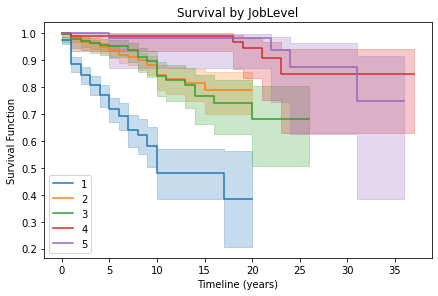

In [31]:
categories = [('Gender', ['Male', 'Female']),
              ('Department', ['Sales', 'Research & Development', 'Human Resources']),
              ('JobLevel', [1, 2, 3, 4, 5])]

for category, values in categories:
    fig, ax = plt.subplots()
    for value in values:
        mask = shifted[category] == value
        kmf.fit(T[mask], E[mask], label=value)
        kmf.plot_survival_function(ax=ax)
    plt.tight_layout()
    plt.xlabel('Timeline (years)')
    plt.ylabel('Survival Function')
    plt.title(f"Survival by {category}")


Cox Proportional Hazard Model (Semi-Parametric)

Assumptions
- Independence of survival times between distinct individuals in the sample
- A multiplicative relationship between the predictors and the hazard, and
- A constant hazard ratio over time.

Definition of Hazard and Hazard Ratio

- Hazard is defined as the slope of the survival curve. It is a measure of how rapidly subjects are churning.
- The hazard ratio compares two groups. If the hazard ratio is 2.0, then the rate of attrition in one group is twice the rate in the other group.

In [32]:
dum_depart = pd.get_dummies(shifted["Department"], prefix = 'Department')
dum_level = pd.get_dummies(shifted["JobLevel"], prefix = 'JobLevel')
dum_edu = pd.get_dummies(shifted["Education"], prefix = 'Education')

dum = pd.concat([dum_depart, dum_level, dum_edu], axis = 1)
dum = dum.rename(columns={'Department_Human Resources': 'Department_HR', 'Department_Research & Development': 'Department_R&D'})

In [33]:
dum.head()

,Department_HR,Department_R&D,Department_Sales,JobLevel_1,JobLevel_2,JobLevel_3,JobLevel_4,JobLevel_5,Education_1,Education_2,Education_3,Education_4,Education_5
0,0,0,1,0,1,0,0,0,0,1,0,0,0
1,0,1,0,0,1,0,0,0,1,0,0,0,0
2,0,1,0,1,0,0,0,0,0,1,0,0,0
3,0,1,0,1,0,0,0,0,0,0,0,1,0
4,0,1,0,1,0,0,0,0,1,0,0,0,0


In [34]:
ndf = pd.concat([shifted, dum], axis =1)
ndf = ndf.drop(['Department', 'JobLevel', 'Education'], axis=1)
ndf.head()

,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,...,JobLevel_1,JobLevel_2,JobLevel_3,JobLevel_4,JobLevel_5,Education_1,Education_2,Education_3,Education_4,Education_5
0,41,Yes,Travel_Rarely,1102,1,Life Sciences,1,1,2,Female,...,0,1,0,0,0,0,1,0,0,0
1,49,No,Travel_Frequently,279,8,Life Sciences,1,2,3,Male,...,0,1,0,0,0,1,0,0,0,0
2,37,Yes,Travel_Rarely,1373,2,Other,1,4,4,Male,...,1,0,0,0,0,0,1,0,0,0
3,33,No,Travel_Frequently,1392,3,Life Sciences,1,5,4,Female,...,1,0,0,0,0,0,0,0,1,0
4,27,No,Travel_Rarely,591,2,Medical,1,7,1,Male,...,1,0,0,0,0,1,0,0,0,0


In [35]:
kdf = ndf[['Age','status', 'GenderBin', 'YearsAtCompany','Department_HR','Department_R&D','Department_Sales','JobLevel_1','JobLevel_2','JobLevel_3','JobLevel_4','JobLevel_5','Education_1','Education_2', 'Education_3', 'Education_4', 'Education_5']]      
kdf.head()


,Age,status,GenderBin,YearsAtCompany,Department_HR,Department_R&D,Department_Sales,JobLevel_1,JobLevel_2,JobLevel_3,JobLevel_4,JobLevel_5,Education_1,Education_2,Education_3,Education_4,Education_5
0,41,1,1,6,0,0,1,0,1,0,0,0,0,1,0,0,0
1,49,0,0,10,0,1,0,0,1,0,0,0,1,0,0,0,0
2,37,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0
3,33,0,1,8,0,1,0,1,0,0,0,0,0,0,0,1,0
4,27,0,0,2,0,1,0,1,0,0,0,0,1,0,0,0,0


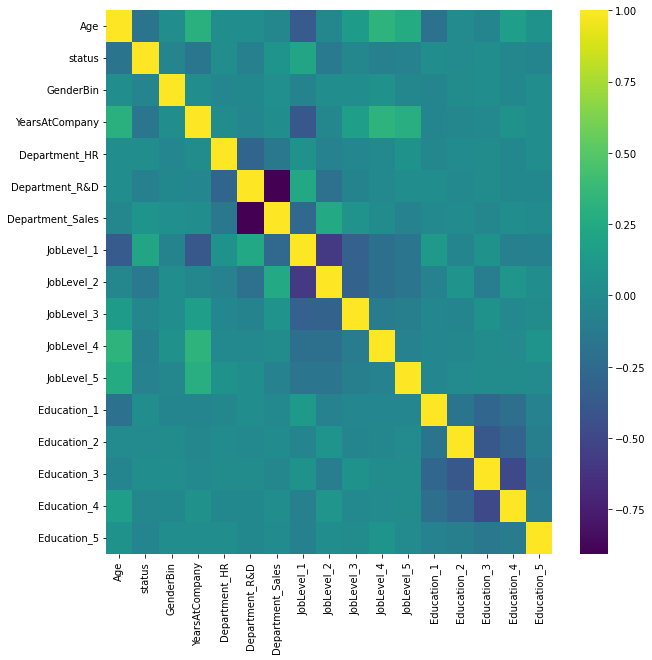

In [36]:
# Checking correlation matrix
corr = kdf.corr()

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=False, annot_kws={"size": 12}, cmap="viridis")
plt.show()

In [37]:
cph = CoxPHFitter(penalizer=0.1).fit(kdf, duration_col = 'YearsAtCompany', event_col = 'status', show_progress=True)
cph.print_summary()

Iteration 1: norm_delta = 0.61259, step_size = 0.9500, log_lik = -1567.76567, newton_decrement = 81.28170, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.07619, step_size = 0.9500, log_lik = -1488.72244, newton_decrement = 1.23205, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00590, step_size = 0.9500, log_lik = -1487.48316, newton_decrement = 0.00600, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00002, step_size = 1.0000, log_lik = -1487.47714, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 4 iterations.


<lifelines.CoxPHFitter: fitted with 1467 total observations, 1233 right-censored observations>
             duration col = 'YearsAtCompany'
                event col = 'status'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1467
number of events observed = 234
   partial log-likelihood = -1487.48
         time fit was run = 2023-01-31 14:16:59 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                
Age               -0.03       0.97       0.01            -0.04            -0.02                 0.96                 0.98
GenderBin         -0.09       0.91       0.11            -0.30             0.12                 0.74                 1.13
Department_HR     -0.04       0.96       0.25            -0.53             0.46                 0.59                 1.58
Department_R&D    -0.27       0.76       0.14            -0.53            -0.00                 0.59                 1.00
Department_Sales   0.30       1.34       0.14             0.02             0.57                 1.02                 1.76
JobLevel_1         0.83       2.28       0.13             0.57             1.08                 1.77                 2.94
JobLevel_2        -0.35       0.71       0.13            -0.60            -0.10                 0.55                 0.91
JobLevel_3        -0.24       0.79       0.16            -0.55             0.07                 0.57                 1.07
JobLevel_4        -0.75       0.47       0.23            -1.20            -0.30                 0.30                 0.74
JobLevel_5        -0.70       0.49       0.28            -1.25            -0.16                 0.29                 0.85
Education_1       -0.04       0.96       0.17            -0.37             0.29                 0.69                 1.34
Education_2        0.03       1.03       0.15            -0.26             0.31                 0.77                 1.37
Education_3        0.07       1.07       0.12            -0.17             0.31                 0.84                 1.36
Education_4       -0.05       0.95       0.13            -0.31             0.21                 0.73                 1.23
Education_5       -0.20       0.82       0.33            -0.85             0.45                 0.43                 1.57

                   cmp to     z      p   -log2(p)
covariate                                        
Age                  0.00 -4.70 <0.005      18.55
GenderBin            0.00 -0.85   0.40       1.33
Department_HR        0.00 -0.14   0.89       0.17
Department_R&D       0.00 -1.99   0.05       4.42
Department_Sales     0.00  2.13   0.03       4.92
JobLevel_1           0.00  6.40 <0.005      32.56
JobLevel_2           0.00 -2.70   0.01       7.15
JobLevel_3           0.00 -1.51   0.13       2.93
JobLevel_4           0.00 -3.25 <0.005       9.77
JobLevel_5           0.00 -2.53   0.01       6.47
Education_1          0.00 -0.22   0.83       0.27
Education_2          0.00  0.19   0.85       0.23
Education_3          0.00  0.56   0.58       0.79
Education_4          0.00 -0.40   0.69       0.53
Education_5          0.00 -0.61   0.54       0.88
---
Concordance = 0.79
Partial AIC = 3004.95
log-likelihood ratio test = 160.58 on 15 df
-log2(p) of ll-ratio test = 85.46

Interpretation

- Age has a coefficient of about -0.03. In a Cox proportional hazard model, a higher hazard means more at risk of the event occurring. 
Here, the value of exp(0.83) [2.28] is the hazard ratio.

- It shows that a one unit increase in age means the baseline hazard will increase by a factor of exp(-0.03) [0.97] ⇾ about a 1% decrease. 
  
- Similarly, the values in the JobLevel column are: [1, 2, 3, 4, 5]. The value of the coefficient associated with 1, exp(0.83) [2.28], is the Hazard Ratio associated with having "JobLevel = 1" compared to other levels. This indicates the risk (rate) of churning is 2.28 times for employees who are at the lowest job level compared to more senior employees.

<AxesSubplot: xlabel='log(HR) (95% CI)'>

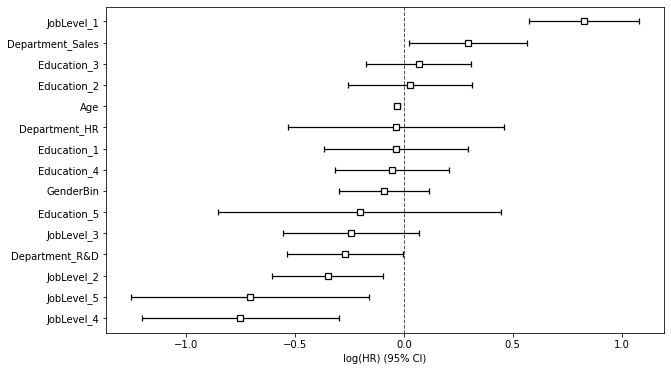

In [38]:
# rank variables by log(HR)
plt.subplots(figsize = (10, 6))
cph.plot()

<AxesSubplot: >

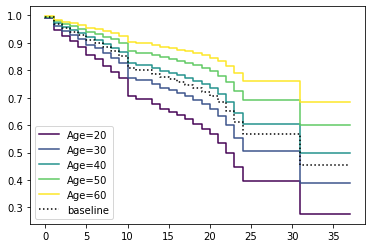

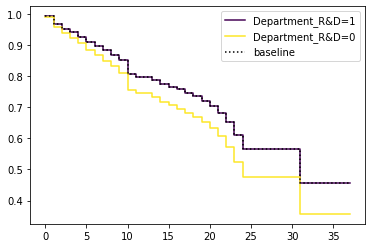

In [39]:
# Plot Partial Effects on Outcome (Cox-PH Regression)
cph.plot_partial_effects_on_outcome(covariates = 'Age', values = [20, 30, 40, 50, 60], cmap="viridis")
cph.plot_partial_effects_on_outcome(covariates = 'Department_R&D', values = [1,0], cmap="viridis")

In [40]:
"""
Check Proportional Hazard Assumption

The null (H0) hypothesis assumed that the proportional hazard criteria satisfied, 
while alternative hypothesis (H1) infers that the proportional hazard assumption is not met.
"""

cph.check_assumptions(kdf, p_value_threshold = 0.05)

Proportional hazard assumption looks okay.


[]

In [42]:
# alternative assumption check
results = proportional_hazard_test(cph, kdf, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 1467 total observations, 1233 right-censored observations>
         test_name = proportional_hazard_test

---
                  test_statistic    p  -log2(p)
Age                         3.25 0.07      3.81
Department_HR               0.00 0.96      0.06
Department_R&D              0.01 0.91      0.14
Department_Sales            0.01 0.92      0.13
Education_1                 0.01 0.93      0.11
Education_2                 0.13 0.71      0.49
Education_3                 0.81 0.37      1.44
Education_4                 2.04 0.15      2.71
Education_5                 0.19 0.66      0.59
GenderBin                   0.19 0.66      0.60
JobLevel_1                  0.00 0.96      0.06
JobLevel_2                  0.32 0.57      0.81
JobLevel_3                  0.36 0.55      0.86
JobLevel_4                  1.65 0.20      2.33
JobLevel_5                  0.77 0.38      1.40

No p values below 0.05 threshold so null hypothesis satisfied

Next steps:
- Given a team, what is the likely churn in the next 12 months, 18 months, 24 months. 
- What job level/role are most at risk of leaving.
